# First-Visit Monte Carlo Tahmini Algoritması

### Amaç
Belirli bir politikanın ($\pi$) durum-değer fonksiyonunu ($V(s)$) tahmin etmek.

First-Visit Monte Carlo algoritmasının temel amacı, bir politikanın ($\pi$) belirli bir durumda (state) uygulanması durumunda, bu durumdan itibaren elde edilecek beklenen toplam ödülü (state-value function), ($V(s)$) tahmin etmektir. Yani algoritma, her bir durumun "değerini" öğrenmeye çalışır. Bu, özellikle çevrenin dinamikleri (geçiş olasılıkları ve ödül dağılımları) bilinmediğinde, deneyimlerden (örneklerden) öğrenmek için kullanılır.

---

### Algoritma
1. **Girdi:** Değerlendirilecek bir politika $\pi$
2. **Başlat:**
   - $V(s)$: Tüm durumlar için default bir başlangıç değeri
   - $\text{Returns}(s)$: Her durum için başlangıçta boş bir liste
3. **Her bir bölüm için:**
   - Episodu $\pi$ politikasını takip ederek oluştur:
     $$
     S_0, A_0, R_1, S_1, A_1, R_2, \dots, S_{T-1}, A_{T-1}, R_T
     $$
   - Geri dönüşü başlat: $G \gets 0$
   - Episodun her bir adımı için (sondan başa doğru):
     - $G \gets \gamma G + R_{t+1}$ (Geri dönüşü güncelle)
     - Eğer $S_t$ daha önce episode'da görülmediyse:
       - $G$ değerini $\text{Returns}(S_t)$ listesine ekle
       - $V(S_t) \gets \text{Returns}(S_t)$ listesinin ortalamasını al

---

### Notlar
- İlk ziyaret edilen durumlar (First-Visit) dikkate alınır.
- $\gamma$: Gelecek ödüller için indirim faktörü (genellikle $\gamma = 1$ olarak alınır).
- $V(s)$, her durumun beklenen toplam ödülünü ifade eder.

---

## 1)

In [1]:
def first_visit_mc_prediction(policy, env, gamma=1.0, episodes=1000):
    # Başlatma
    V = defaultdict(float)  # Durum-değer fonksiyonu
    Returns = defaultdict(list)  # Durum başına getiriler

    for episode_num in range(episodes):
        # Epizot oluştur
        episode = []
        state = env.reset()  # Ortamı sıfırla ve başlangıç durumunu al
        done = False

        while not done:
            action = policy(state)  # Politika ile aksiyon seç
            next_state, reward, done, _ = env.step(action)  # Aksiyon uygula
            episode.append((state, reward))  # Durumu ve ödülü kaydet
            state = next_state  # Sonraki duruma geç

        # Epizodu tersten işle
        G = 0  # Geri dönüş
        visited_states = set()

        for t in reversed(range(len(episode))):
            state, reward = episode[t]
            G = gamma * G + reward  # Geri dönüşü güncelle

            # İlk ziyaret kontrolü
            if state not in visited_states:
                visited_states.add(state)
                Returns[state].append(G)  # G'yi Returns'e ekle
                V[state] = np.mean(Returns[state])  # Ortalama geri dönüş

    return V

## 2)

In [2]:
import numpy as np
import random
from collections import defaultdict
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [3]:
# Kart değerleri
card_values = {"2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7, "8": 8, 
               "9": 9, "10": 10, "J": 10, "Q": 10, "K": 10, "A": 1}
cards = list(card_values.keys())

In [4]:
# Kart çekme fonksiyonu
def draw_card():
    return random.choice(cards)

In [5]:
def calculate_hand_value(hand):
    value = 0
    num_aces = hand.count("A")
    
    # Önce As olmayan kartları topla (2 tane AS da olabilir!)
    for card in hand:
        if card != "A":
            value += card_values[card]
    
    # As'ları ekle
    for _ in range(num_aces):
        if value + 11 <= 21:
            value += 11
        else:
            value += 1
    return value

In [6]:
# Doğal blackjack kontrolü
def has_natural(hand):
    return sorted(hand) == ["A", "10"]

In [7]:
# Oyuncu veya krupiye patladi mi?
def is_bust(hand):
    return calculate_hand_value(hand) > 21

In [8]:
# Kullanılabilir As kontrolü
def has_usable_ace(hand):
    return "A" in hand and calculate_hand_value(hand) <= 21

In [9]:
# Dealer'ın sabit politikası
def dealer_policy(hand):
    return "hit" if calculate_hand_value(hand) < 17 else "stick"

In [10]:
# Oyuncunun politikası
def player_policy(hand):
    return "stick" if calculate_hand_value(hand) >= 20 else "hit"

In [11]:
# Blackjack oyunu: Episode üretimi
def play_blackjack(player_policy):
    episode = []
    player_hand = [draw_card(), draw_card()]
    dealer_hand = [draw_card(), draw_card()]
    
    # Doğal blackjack kontrolü
    if has_natural(player_hand):
        if has_natural(dealer_hand):
            episode.append(((calculate_hand_value(player_hand), 
                             card_values[dealer_hand[0]],
                             has_usable_ace(player_hand)), "stick", 0))
            return episode
        
        episode.append(((calculate_hand_value(player_hand),
                         card_values[dealer_hand[0]],
                         has_usable_ace(player_hand)), "stick", 1))
        return episode

    # Oyuncunun turu
    while True:
        state = (calculate_hand_value(player_hand), card_values[dealer_hand[0]], has_usable_ace(player_hand))
        action = player_policy(player_hand)
        if action == "stick":
            episode.append((state, action, 0))
            break
        player_hand.append(draw_card())
        if is_bust(player_hand):
            episode.append((state, action, -1))
            return episode
        episode.append((state, action, 0))
    
    # Dealer'ın turu
    while dealer_policy(dealer_hand) == "hit":
        dealer_hand.append(draw_card())
    
    # Sonuç hesaplama
    player_total = calculate_hand_value(player_hand)
    dealer_total = calculate_hand_value(dealer_hand) 
    
    if player_total > dealer_total or dealer_total > 21:
        reward = 1  # Oyuncu kazandı
    elif player_total < dealer_total:
        reward = -1  # Oyuncu kaybetti
    else:
        reward = 0  # Berabere
    
    episode[-1]  = (episode[-1][0], episode[-1][1], reward)  # Son ödülü güncelle
    
    return episode

In [12]:
# First-Visit MC Prediction
def first_visit_mc_prediction_blackjack(player_policy, episodes=500000, gamma=1.0):
    value_table = defaultdict(float)
    returns = defaultdict(list)
    
    for episode_num in range(episodes):
        episode = play_blackjack(player_policy)
        visited_states = set()
        G = 0
        
        # Epizodu tersten işleyerek G'yi hesaplayalim
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if state not in visited_states:
                visited_states.add(state)
                returns[state].append(G)
                value_table[state] = np.mean(returns[state])
        # loglayalim
        if episode_num % 10000 == 0:
            print(f"Episode {episode_num}")
    
    return value_table

In [13]:
# Durumları işlemeye yönelik fonksiyon, gorsellestirmek icin kullanmamiz lazim
def process_states(value_table, usable_ace):
    values = np.zeros((10, 10))
    for (player_sum, dealer_card, ace), value in value_table.items():
        if ace == usable_ace and 12 <= player_sum <= 21 and 1 <= dealer_card <= 10:
            values[player_sum - 12, dealer_card - 1] = value

    # Normalizasyon
    min_val = np.min(values)
    max_val = np.max(values)
    if max_val > min_val:
        values = 2 * (values - min_val) / (max_val - min_val) - 1
    
    return values

In [14]:
# Ana kod içinde değiştirilecek kısım:
print("Monte Carlo tahminleri çalışıyor...")
print("500.000'lik episode hesaplaniyor...")
value_table_500k = first_visit_mc_prediction_blackjack(player_policy, episodes=500000)
print("Tamamlandı.")
print("10.000'lik episode hesaplaniyor...")
value_table_10k = first_visit_mc_prediction_blackjack(player_policy, episodes=10000)
print("Tamamlandı.")

Monte Carlo tahminleri çalışıyor...
500.000'lik episode hesaplaniyor...
Episode 0
Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Episode 60000
Episode 70000
Episode 80000
Episode 90000
Episode 100000
Episode 110000
Episode 120000
Episode 130000
Episode 140000
Episode 150000
Episode 160000
Episode 170000
Episode 180000
Episode 190000
Episode 200000
Episode 210000
Episode 220000
Episode 230000
Episode 240000
Episode 250000
Episode 260000
Episode 270000
Episode 280000
Episode 290000
Episode 300000
Episode 310000
Episode 320000
Episode 330000
Episode 340000
Episode 350000
Episode 360000
Episode 370000
Episode 380000
Episode 390000
Episode 400000
Episode 410000
Episode 420000
Episode 430000
Episode 440000
Episode 450000
Episode 460000
Episode 470000
Episode 480000
Episode 490000
Tamamlandı.
10.000'lik episode hesaplaniyor...
Episode 0
Tamamlandı.


In [15]:
usable_ace_values_10k      = process_states(value_table_10k, usable_ace=1)
non_usable_ace_values_10k  = process_states(value_table_10k, usable_ace=0)
usable_ace_values_500k     = process_states(value_table_500k, usable_ace=1)
non_usable_ace_values_500k = process_states(value_table_500k, usable_ace=0)

In [16]:
# Değerleri pürüzsüz hale getirmek için hareketli ortalama (smoothing) / kitapkaine daha benzer bir görsel sonuç için
non_usable_ace_values_500k_smoothed = gaussian_filter(non_usable_ace_values_500k, sigma=0.5)
usable_ace_values_500k_smoothed     = gaussian_filter(usable_ace_values_500k, sigma=0.5)
non_usable_ace_values_10k_smoothed  = gaussian_filter(non_usable_ace_values_10k, sigma=0.5)
usable_ace_values_10k_smoothed      = gaussian_filter(usable_ace_values_10k, sigma=0.5)

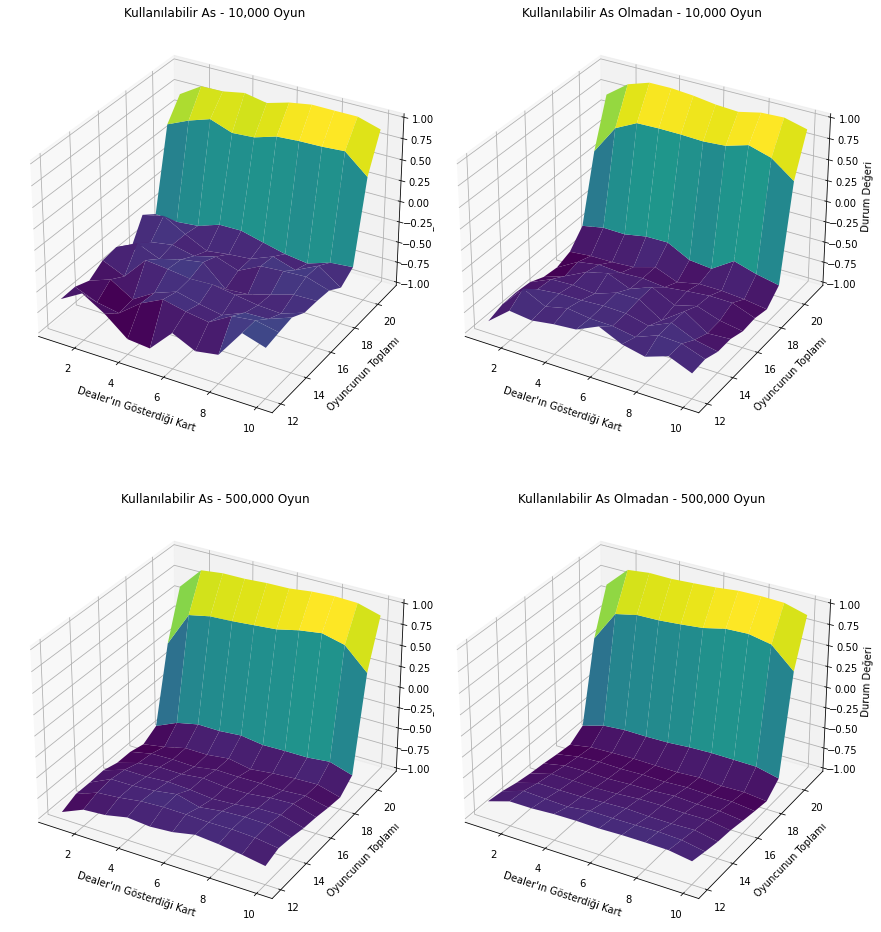


Örnek durum değerleri:
Durum (20, 10, False): 0.43510492700729925
Durum (19, 10, False): -0.7448123620309051
Durum (18, 10, False): -0.7322856820998085


In [17]:
# Görselleştirme
fig = plt.figure(figsize=(12, 14))

# Grafik ayarları
X, Y = np.meshgrid(range(1, 11), range(12, 22))

# Kullanılabilir As - 10,000 Oyun
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, usable_ace_values_10k_smoothed, cmap='viridis')
ax1.set_title('Kullanılabilir As - 10,000 Oyun')
ax1.set_xlabel('Dealer\'ın Gösterdiği Kart')
ax1.set_ylabel('Oyuncunun Toplamı')
ax1.set_zlabel('Durum Değeri')
ax1.set_zlim(-1, 1)

# Kullanılabilir As Olmadan - 10,000 Oyun
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X, Y, non_usable_ace_values_10k_smoothed, cmap='viridis')
ax2.set_title('Kullanılabilir As Olmadan - 10,000 Oyun')
ax2.set_xlabel('Dealer\'ın Gösterdiği Kart')
ax2.set_ylabel('Oyuncunun Toplamı')
ax2.set_zlabel('Durum Değeri')
ax2.set_zlim(-1, 1)

# Kullanılabilir As - 500,000 Oyun
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X, Y, usable_ace_values_500k_smoothed, cmap='viridis')
ax3.set_title('Kullanılabilir As - 500,000 Oyun')
ax3.set_xlabel('Dealer\'ın Gösterdiği Kart')
ax3.set_ylabel('Oyuncunun Toplamı')
ax3.set_zlabel('Durum Değeri')
ax3.set_zlim(-1, 1)

# Kullanılabilir As Olmadan - 500,000 Oyun
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X, Y, non_usable_ace_values_500k_smoothed, cmap='viridis')
ax4.set_title('Kullanılabilir As Olmadan - 500,000 Oyun')
ax4.set_xlabel('Dealer\'ın Gösterdiği Kart')
ax4.set_ylabel('Oyuncunun Toplamı')
ax4.set_zlabel('Durum Değeri')
ax4.set_zlim(-1, 1)

plt.tight_layout()
plt.show()

# Bazı örnek durumlar için değerleri yazdır
print("\nÖrnek durum değerleri:")
for state in [(20, 10, False), (19, 10, False), (18, 10, False)]:
    print(f"Durum {state}: {value_table_500k.get(state, 'Değer bulunamadı')}")

In [18]:
# Test örnekleri
print(calculate_hand_value(["A", "10"]))  # 21 olmalı
print(calculate_hand_value(["A", "5", "5"]))  # 21 olmalı
print(dealer_policy(["10", "6"]))  # "hit" olmalı
print(dealer_policy(["10", "7"]))  # "stick" olmalı

21
21
hit
stick
